In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chatbots-intent-recognition-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F935560%2F1582026%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240509%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240509T142339Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6eb90aed7f9461fba0d2480b53423c0867c081a205fc591c3c1b05a146df930277c7805ebea4d3b11e8f7f70e4ab0fdbf09e5bc55c8d10d0adc5880f208c9dd8a38a71431b4a8f60e9575719ca5787f6f241d08d9004e57de29cbf3edd674220277aa04c6fbd02c0e4cba6003dd95bd23cf96819247410a986d6d41720bde123f5f19f18bfa08637fecf6120c37cdd42a88d46571d102117668c4a98f12447b8c7fb01cac1535fa8ac187580e3b84c612569c336642c90883c52cde0708a58655c3f15abbc2ddb29785b0d74c70174a19d073c4a4068acd914f821f0d535d507d18eb82de8ef4c22c39e6e20b0d304f753bd7297f7540fec3a9db10742b34393'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 17262 bytes downloaded
Downloaded and uncompressed: chatbots-intent-recognition-dataset
Data source import complete.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os
import io
import nltk
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense,GlobalAveragePooling1D,Flatten, Dropout , GRU
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv1D, MaxPool1D
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chatbots-intent-recognition-dataset/Intent.json


In [ ]:
data=pd.read_json('/kaggle/input/chatbots-intent-recognition-dataset/Intent.json')
data.head()

,intents
0,"{'intent': 'Greeting', 'text': ['Hi', 'Hi ther..."
1,"{'intent': 'GreetingResponse', 'text': ['My us..."
2,"{'intent': 'CourtesyGreeting', 'text': ['How a..."
3,"{'intent': 'CourtesyGreetingResponse', 'text':..."
4,"{'intent': 'CurrentHumanQuery', 'text': ['What..."


In [ ]:
def processing_json_dataset(data):
    tags = []
    inputs = []
    responses={}
    for intent in data['intents']:
        responses[intent['intent']]=intent['responses']
        for lines in intent['text']:
            inputs.append(lines)
            tags.append(intent['intent'])
    return [tags, inputs, responses]

In [ ]:
[tags, inputs, responses] = processing_json_dataset(data)


In [ ]:
dataset = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

In [ ]:
dataset.head()

,inputs,tags
0,Hi,Greeting
1,Hi there,Greeting
2,Hola,Greeting
3,Hello,Greeting
4,Hello there,Greeting


In [ ]:
dataset = dataset.sample(frac=1)
dataset.head()

,inputs,tags
50,What is the time?,TimeQuery
70,Do you understand what I am saying,UnderstandQuery
92,"Thanks for the help, goodbye",CourtesyGoodBye
117,Do you know any jokes,Jokes
78,Stop talking,Shutup


In [ ]:
import string
dataset['inputs'] = dataset['inputs'].apply(lambda sequence:
                                            [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])
dataset.head()

,inputs,tags
50,"[w, h, a, t, , i, s, , t, h, e, , t, i, m, e]",TimeQuery
70,"[d, o, , y, o, u, , u, n, d, e, r, s, t, a, ...",UnderstandQuery
92,"[t, h, a, n, k, s, , f, o, r, , t, h, e, , ...",CourtesyGoodBye
117,"[d, o, , y, o, u, , k, n, o, w, , a, n, y, ...",Jokes
78,"[s, t, o, p, , t, a, l, k, i, n, g]",Shutup


In [ ]:
dataset['inputs'] = dataset['inputs'].apply(lambda wrd: ''.join(wrd))
dataset.head()

,inputs,tags
50,what is the time,TimeQuery
70,do you understand what i am saying,UnderstandQuery
92,thanks for the help goodbye,CourtesyGoodBye
117,do you know any jokes,Jokes
78,stop talking,Shutup


In [ ]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(dataset['inputs'])
train = tokenizer.texts_to_sequences(dataset['inputs'])
features = pad_sequences(train)
le = LabelEncoder()
labels = le.fit_transform(dataset['tags'])

In [ ]:
len(features[0])

9

In [ ]:
input_shape = features.shape[1]
print(input_shape)

9


In [ ]:
features.shape

(143, 9)

In [ ]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  117
output length:  22


In [ ]:
tokenizer.word_index


{'you': 1,
 'is': 2,
 'me': 3,
 'are': 4,
 'i': 5,
 'what': 6,
 'the': 7,
 'do': 8,
 'thanks': 9,
 'can': 10,
 'name': 11,
 'am': 12,
 'please': 13,
 'your': 14,
 'pod': 15,
 'bay': 16,
 'door': 17,
 'a': 18,
 'tell': 19,
 'open': 20,
 'bella': 21,
 'adam': 22,
 'time': 23,
 'not': 24,
 'to': 25,
 'prove': 26,
 'real': 27,
 'talking': 28,
 'my': 29,
 'why': 30,
 'how': 31,
 'it': 32,
 'gossip': 33,
 'know': 34,
 'see': 35,
 'call': 36,
 'good': 37,
 'goodbye': 38,
 'user': 39,
 'thank': 40,
 'great': 41,
 'this': 42,
 'bye': 43,
 'wasnt': 44,
 'who': 45,
 'hello': 46,
 'very': 47,
 'for': 48,
 'any': 49,
 'will': 50,
 'clever': 51,
 'girl': 52,
 'have': 53,
 'conscious': 54,
 'doing': 55,
 'well': 56,
 'quiet': 57,
 'ok': 58,
 'some': 59,
 'hi': 60,
 'there': 61,
 'joke': 62,
 'understand': 63,
 'saying': 64,
 'anyone': 65,
 'in': 66,
 'camera': 67,
 'genious': 68,
 'selfaware': 69,
 'hope': 70,
 'hya': 71,
 'be': 72,
 'up': 73,
 'think': 74,
 'fuck': 75,
 'hola': 76,
 'intelligent': 7

In [ ]:
model = Sequential()
model.add(Input(shape=(features.shape[1])))
model.add(Embedding(vocabulary + 1,100))
model.add(Conv1D(filters=32, kernel_size=5, activation="relu", kernel_initializer=tf.keras.initializers.GlorotNormal(),bias_regularizer=tf.keras.regularizers.L2(0.0001), kernel_regularizer=tf.keras.regularizers.L2(0.0001), activity_regularizer = tf.keras.regularizers.L2(0.0001)))
model.add(Dropout(0.3))
model.add(LSTM(32, dropout=0.3,return_sequences=True))
model.add(LSTM(16, dropout=0.3,return_sequences=False))
model.add(Dense(128,activation="relu", activity_regularizer = tf.keras.regularizers.L2(0.0001)))
model.add(Dropout(0.6))
model.add(Dense(output_length, activation="softmax", activity_regularizer = tf.keras.regularizers.L2(0.0001)))

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2024-05-09 14:30:11--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-05-09 14:30:11--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 39s  

2024-05-09 14:32:50 (5.18 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
model.layers

In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
glove_dir = "glove.6B.100d.txt"
embeddings_index = {}
file_ = open(glove_dir)
for line in file_:
    arr = line.split()
    single_word = arr[0]
    w = np.asarray(arr[1:],dtype='float32')
    embeddings_index[single_word] = w
file_.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
max_words = vocabulary + 1
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words,100)).astype(object)
for word , i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])


In [ ]:
from keras.callbacks import TensorBoard, EarlyStopping
earlyStopping = EarlyStopping(monitor = 'loss', patience = 400, mode = 'min', restore_best_weights = True)

In [ ]:
history_training = model.fit(features,labels,epochs=1000, batch_size=64, callbacks=[ earlyStopping])


Epoch 1/1000
3/3 [==============================] - 4s 20ms/step - loss: 3.1032 - accuracy: 0.0350
Epoch 2/1000
3/3 [==============================] - 0s 12ms/step - loss: 3.0977 - accuracy: 0.0350
Epoch 3/1000
3/3 [==============================] - 0s 11ms/step - loss: 3.0931 - accuracy: 0.0490
Epoch 4/1000
3/3 [==============================] - 0s 10ms/step - loss: 3.0932 - accuracy: 0.0769
Epoch 5/1000
3/3 [==============================] - 0s 11ms/step - loss: 3.0921 - accuracy: 0.0839
Epoch 6/1000
3/3 [==============================] - 0s 15ms/step - loss: 3.0852 - accuracy: 0.0769
Epoch 7/1000
3/3 [==============================] - 0s 11ms/step - loss: 3.0833 - accuracy: 0.1049
Epoch 8/1000
3/3 [==============================] - 0s 12ms/step - loss: 3.0814 - accuracy: 0.0979
Epoch 9/1000
3/3 [==============================] - 0s 11ms/step - loss: 3.0768 - accuracy: 0.1189
Epoch 10/1000
3/3 [==============================] - 0s 11ms/step - loss: 3.0711 - accuracy: 0.0979
Epoch 11/

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
def draw_plot(data, type_data):
    mpl.style.use('seaborn')
    plt.figure(figsize = (25, 5))
    plt.plot(data,'darkorange', label='Train')
    plt.xlabel('Epoch')
    plt.ylabel(type_data)
    plt.legend()

<ipython-input-28-51922354e33a>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


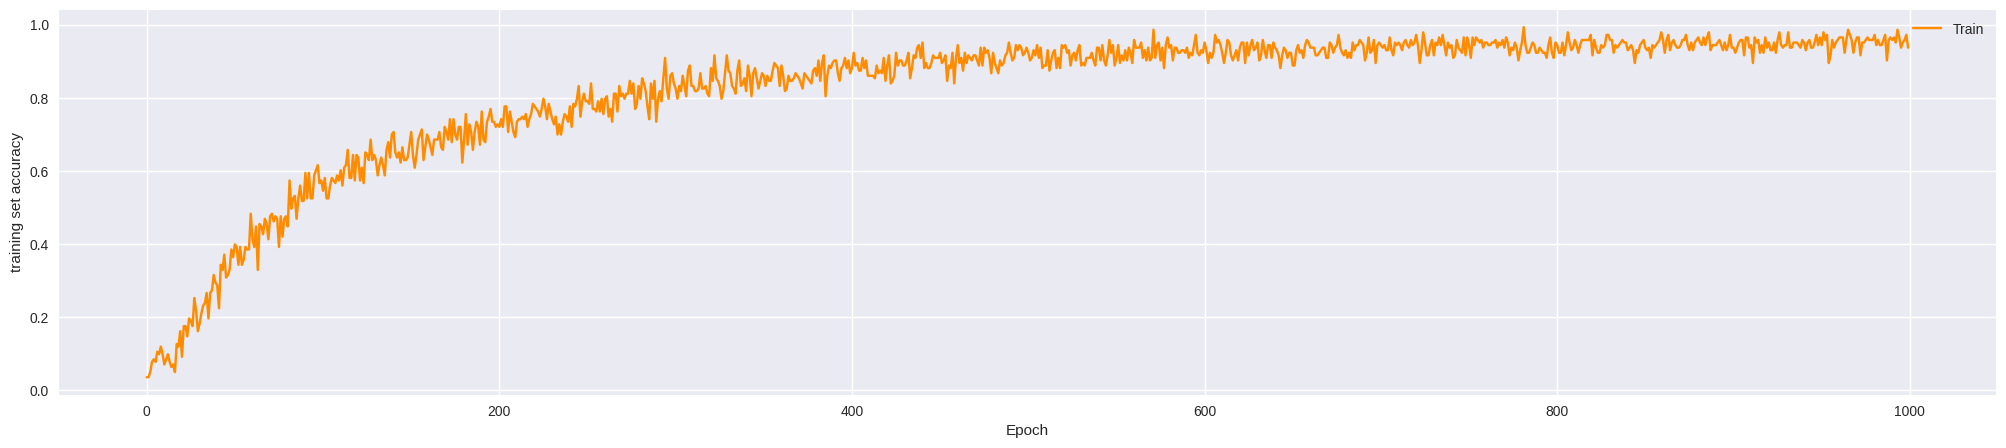

In [ ]:
draw_plot(history_training.history['accuracy'],'training set accuracy' )


In [ ]:
import random
def generate_answer(query):
    texts = []
    pred_input = query
    pred_input = [letters.lower() for letters in pred_input if letters not in string.punctuation]
    pred_input = ''.join(pred_input)
    texts.append(pred_input)
    pred_input = tokenizer.texts_to_sequences(texts)
    pred_input = np.array(pred_input).reshape(-1)
    pred_input = pad_sequences([pred_input],input_shape)
    output = model.predict(pred_input)
    output = output.argmax()
    response_tag = le.inverse_transform([output])[0]
    return random.choice(responses[response_tag])

In [ ]:
list_que = ["hello", "I'm Taha","what is my name?",
            "what is your name?", "tell me please, what is your name?"]
for i in list_que:
    print("you: {}".format(i))
    res_tag = generate_answer(i)
    print(res_tag)

you: hello
1/1 [==============================] - 1s 838ms/step
Hola human, please tell me your GeniSys user
you: I'm Taha
1/1 [==============================] - 0s 21ms/step
I do in deed!
you: what is my name?
1/1 [==============================] - 0s 18ms/step
You are <HUMAN>! How can I help?
you: what is your name?
1/1 [==============================] - 0s 19ms/step
You can call me Geni
you: tell me please, what is your name?
1/1 [==============================] - 0s 19ms/step
Call me Geni
